# Scenario 2 modelling

The scenario 2 turns OAs in the green belt to high-density development.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import contextily 
import palettable.matplotlib as palmpl
import matplotlib.pyplot as plt
import matplotlib.cm
import mapclassify
import husl
import seaborn as sns

from utils import legendgram
import demoland_engine

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_89820/897323822.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
data_folder = "/Users/martin/Library/CloudStorage/OneDrive-SharedLibraries-TheAlanTuringInstitute/Daniel Arribas-Bel - demoland_data"

In [3]:
df = demoland_engine.get_empty()
df.head()

signature_type   use greenspace job_types
geo_code                                           
E00042786           None  None       None      None
E00042707           None  None       None      None
E00042703           None  None       None      None
E00042782           None  None       None      None
E00042789           None  None       None      None

In [4]:
%%time
default = demoland_engine.get_indicators(df, random_seed=42)

CPU times: user 4.15 s, sys: 426 ms, total: 4.58 s
Wall time: 4.46 s


In [5]:
geom = gpd.read_parquet(f"{data_folder}/processed/interpolated/all_oa.parquet")

In [6]:
OAs = ["E00042852", "E00042865", "E00042911", "E00042915"]

In [7]:
df.loc[OAs, "signature_type"] = 8
df.loc[OAs, "greenspace"] = .2

In [8]:
geom[geom.geo_code.isin(OAs)].explore(tooltip="geo_code", popup="geo_code")

In [9]:
changed_2 = demoland_engine.get_indicators(df, random_seed=42)

## Maps

You can plot the two results.

In [10]:
from shapely.geometry import box

bds = geom.total_bounds
extent = gpd.GeoSeries([box((bds[0] - 7000), bds[1], bds[2] + 7000, bds[3])], crs=geom.crs).to_crs(3857)

### Air quality

Text(0.5, 1.0, 'baseline air quality')

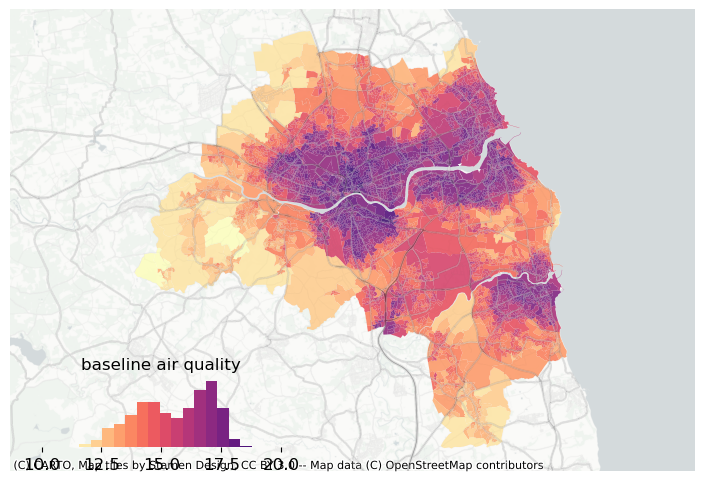

In [11]:
f,ax = plt.subplots(figsize=(9, 6))
extent.plot(ax=ax, alpha=0)
bins = mapclassify.EqualInterval(default.air_quality.values, k=20).bins

legendgram(
    f,
    ax,
    default.air_quality.values,
    bins,
    pal=palmpl.Magma_20_r,
    legend_size=(.35,.15), # legend size in fractions of the axis
    loc = 'lower left', # matplotlib-style legend locations
    clip = (10,20), # clip the displayed range of the histogram
)

geom.assign(pred=default.air_quality.values).to_crs(3857).plot("pred", scheme="userdefined", classification_kwds={"bins": bins}, ax=ax, alpha=.9, cmap="magma_r")
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.title("baseline air quality")


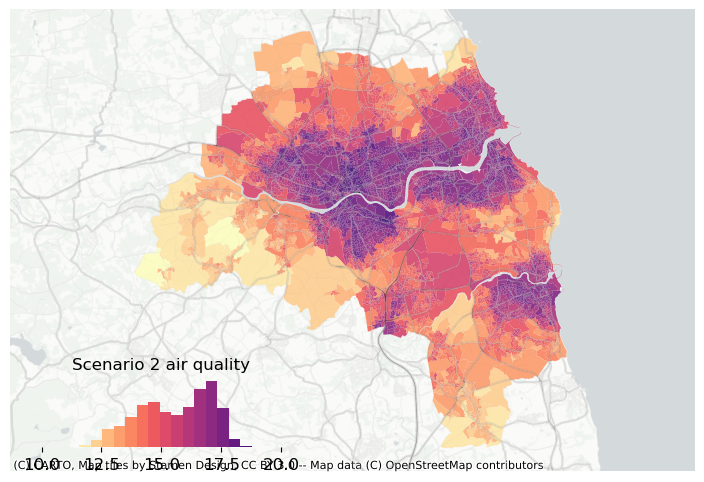

In [12]:
f,ax = plt.subplots(figsize=(9, 6))
extent.plot(ax=ax, alpha=0)

legendgram(
    f,
    ax,
    changed_2.air_quality.values,
    bins,
    pal=palmpl.Magma_20_r,
    legend_size=(.35,.15), # legend size in fractions of the axis
    loc = 'lower left', # matplotlib-style legend locations
    clip = (10,20), # clip the displayed range of the histogram
)

geom.assign(pred=changed_2.air_quality.values).to_crs(3857).plot("pred", scheme="userdefined", classification_kwds={"bins": bins}, ax=ax, alpha=.9, cmap="magma_r")
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.title("Scenario 2 air quality")
plt.savefig(f"{data_folder}/scenarios/figures/scenario2_air_quality.png")

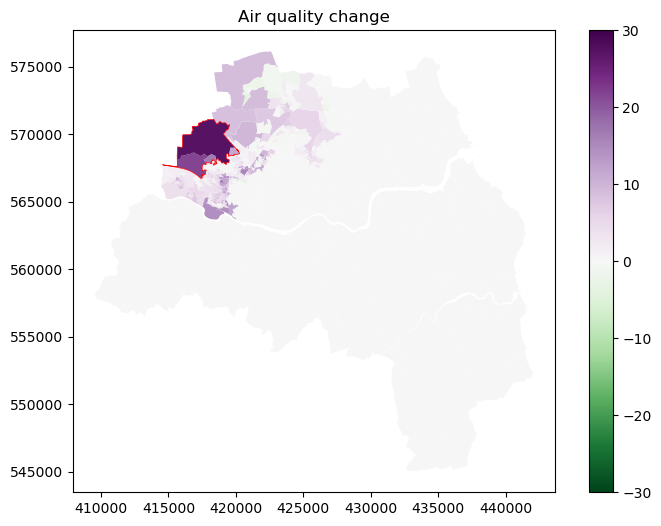

In [13]:
ax = geom.plot((changed_2.air_quality.values - default.air_quality.values) / default.air_quality.values * 100, legend=True, cmap="PRGn_r", vmin=-30, vmax=30, figsize=(9, 6))
geom[geom.geo_code.isin(OAs)].dissolve().boundary.plot(ax=ax, color="red", linewidth=.5)
ax.set_title("Air quality change")
plt.savefig(f"{data_folder}/scenarios/figures/scenario2_air_quality_diff.png")

### House price

Text(0.5, 1.0, 'baseline house price')

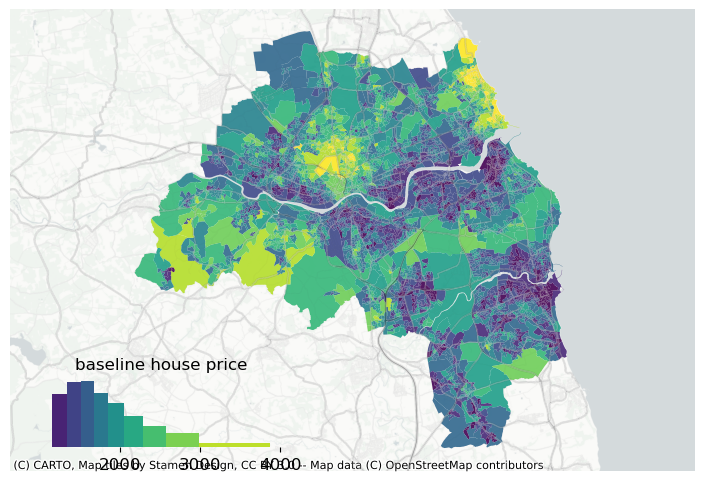

In [14]:
f,ax = plt.subplots(figsize=(9, 6))
extent.plot(ax=ax, alpha=0)
bins = mapclassify.NaturalBreaks(np.exp(default["house_price"].values), k=10).bins

legendgram(
    f,
    ax,
    np.exp(default.house_price.values),
    bins,
    pal=palmpl.Viridis_10,
    legend_size=(.35,.15), # legend size in fractions of the axis
    loc = 'lower left', # matplotlib-style legend locations
    # clip = (10,20), # clip the displayed range of the histogram
)

geom.assign(pred=np.exp(default.house_price.values)).to_crs(3857).plot("pred", scheme="userdefined", classification_kwds={"bins": bins}, ax=ax, alpha=.9, cmap="viridis")
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.title("baseline house price")


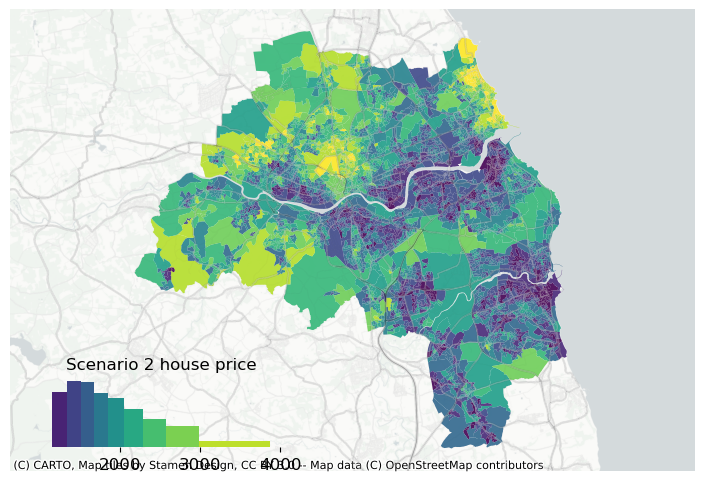

In [15]:
f,ax = plt.subplots(figsize=(9, 6))
extent.plot(ax=ax, alpha=0)

legendgram(
    f,
    ax,
    np.exp(changed_2.house_price.values),
    bins,
    pal=palmpl.Viridis_10,
    legend_size=(.35,.15), # legend size in fractions of the axis
    loc = 'lower left', # matplotlib-style legend locations
    # clip = (10,20), # clip the displayed range of the histogram
)

geom.assign(pred=np.exp(changed_2.house_price.values)).to_crs(3857).plot("pred", scheme="userdefined", classification_kwds={"bins": bins}, ax=ax, alpha=.9, cmap="viridis")
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.title("Scenario 2 house price")
plt.savefig(f"{data_folder}/scenarios/figures/scenario2_house_price.png")



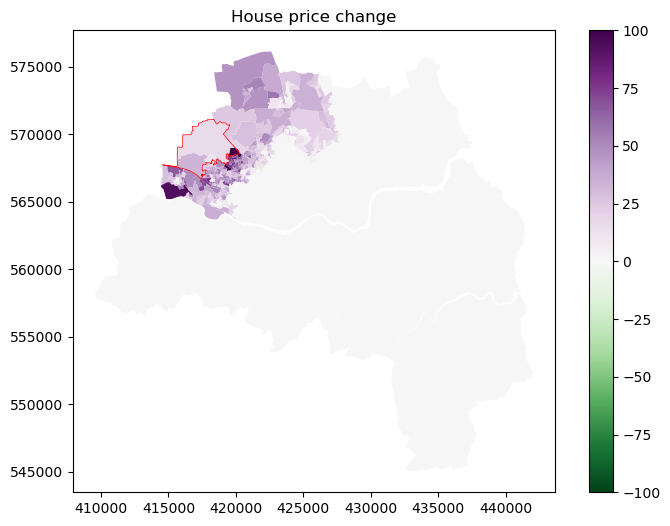

In [16]:
ax = geom.plot((np.exp(changed_2.house_price.values) - np.exp(default.house_price.values)) / np.exp(default.house_price.values) * 100, legend=True, vmin=-100, vmax=100, cmap="PRGn_r",  figsize=(9, 6))
geom[geom.geo_code.isin(OAs)].dissolve().boundary.plot(ax=ax, color="red", linewidth=.5)
ax.set_title("House price change")
plt.savefig(f"{data_folder}/scenarios/figures/scenario2_house_price_diff.png")


### Job accessibility

Text(0.5, 1.0, 'baseline job accessibility')

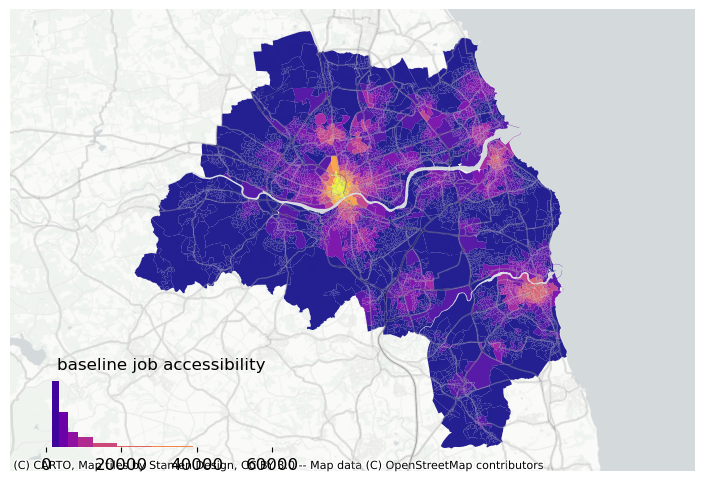

In [17]:
f,ax = plt.subplots(figsize=(9, 6))
extent.plot(ax=ax, alpha=0)
bins = mapclassify.NaturalBreaks(default.job_accessibility.values, k=10).bins

legendgram(
    f,
    ax,
    default.job_accessibility.values,
    bins,
    pal=palmpl.Plasma_10,
    legend_size=(.35,.15), # legend size in fractions of the axis
    loc = 'lower left', # matplotlib-style legend locations
    # clip = (10,20), # clip the displayed range of the histogram
)

geom.assign(pred=default.job_accessibility.values).to_crs(3857).plot("pred", scheme="userdefined", classification_kwds={"bins": bins}, ax=ax, alpha=.9, cmap="plasma")
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.title("baseline job accessibility")


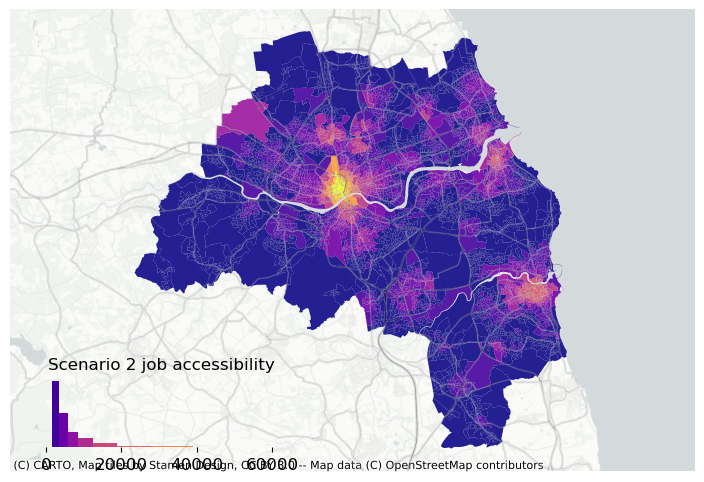

In [18]:
f,ax = plt.subplots(figsize=(9, 6))
extent.plot(ax=ax, alpha=0)

legendgram(
    f,
    ax,
    changed_2.job_accessibility.values,
    bins,
    pal=palmpl.Plasma_10,
    legend_size=(.35,.15), # legend size in fractions of the axis
    loc = 'lower left', # matplotlib-style legend locations
    # clip = (10,20), # clip the displayed range of the histogram
)

geom.assign(pred=changed_2.job_accessibility.values).to_crs(3857).plot("pred", scheme="userdefined", classification_kwds={"bins": bins}, ax=ax, alpha=.9, cmap="plasma")
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.title("Scenario 2 job accessibility")
plt.savefig(f"{data_folder}/scenarios/figures/scenario2_job_acc.png")


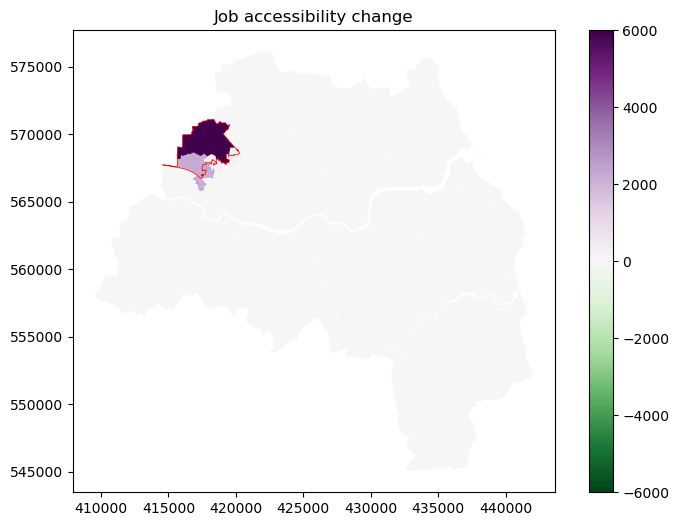

In [19]:
ax = geom.plot((changed_2.job_accessibility.values - default.job_accessibility.values), legend=True, cmap="PRGn_r", figsize=(9, 6), vmin=-6000, vmax=6000)
geom[geom.geo_code.isin(OAs)].dissolve().boundary.plot(ax=ax, color="red", linewidth=.5)
ax.set_title("Job accessibility change")
plt.savefig(f"{data_folder}/scenarios/figures/scenario2_job_acc_diff.png")

### Greenspace accessibility

Text(0.5, 1.0, 'baseline green space accessibility')

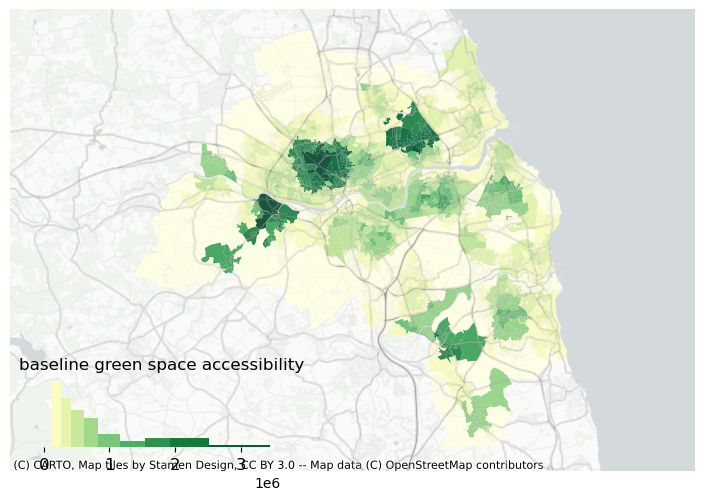

In [20]:
f,ax = plt.subplots(figsize=(9, 6))
extent.plot(ax=ax, alpha=0)
bins = mapclassify.NaturalBreaks(default.greenspace_accessibility.values, k=10).bins

legendgram(
    f,
    ax,
    default.greenspace_accessibility.values,
    bins,
    pal=matplotlib.cm.get_cmap('YlGn'),
    legend_size=(.35,.15), # legend size in fractions of the axis
    loc = 'lower left', # matplotlib-style legend locations
    # clip = (10,20), # clip the displayed range of the histogram
)

geom.assign(pred=default.greenspace_accessibility.values).to_crs(3857).plot("pred", scheme="userdefined", classification_kwds={"bins": bins}, ax=ax, alpha=.9, cmap="YlGn")
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.title("baseline green space accessibility")


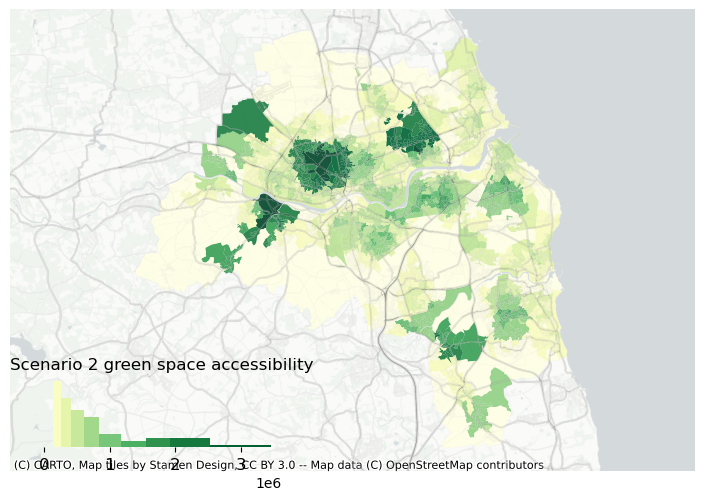

In [21]:
f,ax = plt.subplots(figsize=(9, 6))
extent.plot(ax=ax, alpha=0)

legendgram(
    f,
    ax,
    changed_2.greenspace_accessibility.values,
    bins,
    pal=matplotlib.cm.get_cmap('YlGn'),
    legend_size=(.35,.15), # legend size in fractions of the axis
    loc = 'lower left', # matplotlib-style legend locations
    # clip = (10,20), # clip the displayed range of the histogram
)

geom.assign(pred=changed_2.greenspace_accessibility.values).to_crs(3857).plot("pred", scheme="userdefined", classification_kwds={"bins": bins}, ax=ax, alpha=.9, cmap="YlGn")
ax.set_axis_off()
contextily.add_basemap(ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution="")
contextily.add_basemap(ax=ax, source=contextily.providers.Stamen.TonerLines, alpha=.4, attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors")
plt.title("Scenario 2 green space accessibility")
plt.savefig(f"{data_folder}/scenarios/figures/scenario2_gs_acc.png")

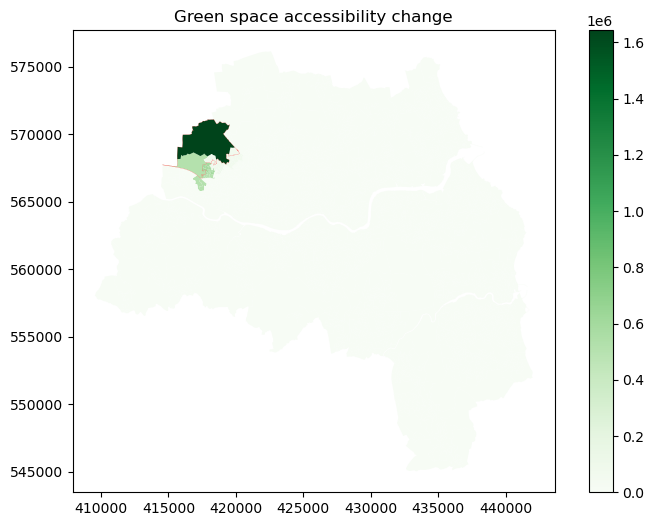

In [22]:
ax = geom.plot(changed_2.greenspace_accessibility.values - default.greenspace_accessibility.values, legend=True, cmap="Greens", figsize=(9, 6))
geom[geom.geo_code.isin(OAs)].dissolve().boundary.plot(ax=ax, color="red", linewidth=.1)
ax.set_title("Green space accessibility change")
plt.savefig(f"{data_folder}/scenarios/figures/scenario2_gs_acc_diff.png")